# Bayesian Learning

This lab introduces you to a Bayesian/probabilistic perspective of Machine Learning. In order to have full information about the underlying distributions, we will for the first time be using *synthetic datasets*, i.e. datasets that we sample ourselves by modelling the distributions explicitly.

These data sets will be used to perform a Bayesian linear regression on the data set. We are looking at the MAP estimate and the posterior distribution on the model parameters. In order to keep it simple, we restrict ourselves to one-dimensional input spaces.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Synthetic Datasets

Our goal in this part is given a marginal distribution $p(x)$ on $\mathbb{R}$, a function $f: \mathbb{R} \rightarrow \mathbb{R}$ to model the conditional distribution $p(y \mid x)$ as follows:

$$ p(y \mid x) = f(x) + \epsilon \qquad \left(\epsilon \sim \mathcal{N}(0, \sigma^2)\right), $$

where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ means that $\epsilon$ is a random variable normally distributed with zero mean and a variance of $\sigma^2$. Note that $f$ actually only has to be defined for $x$ with nonzero probability (this set of $x$ is called the *support of $p$*). Thus, we have fully specified the join distribution $p(x, y) = p(x) p(y \mid x)$.

To generate a data set $D = \{(x_i, y_i) \in X \times Y \mid 1 \leq i \leq N\}$ we then sample tuples $(x, y)$ by first picking a $x$ from the distribution $p(x)$. To compute the $y$ we sample a noise-term $\epsilon$ from the normal distribution with the specified mean and variance, and compute $y = f(x) + \epsilon$. The output $(x, y)$ is then one sample of our data set. Since we sample independently and identically distributed (*i.i.d*) we do this process $N$ times to obtain $D$.

As ground work we first learn about the <a href="http://docs.scipy.org/doc/scipy/reference/stats.html">scipy.stats</a> package, which contains distributions to sample from or computing quantities such as the *probability density function* (*pdf*), and about Python generators.

First we are importing the uniform and normal distribution.

In [2]:
from scipy.stats import uniform
from scipy.stats import norm

In [3]:
# Models uniform distribution on the interval [loc, loc+scale]
b = uniform(loc=0, scale=4)

In [4]:
print "10 samples: {}".format(b.rvs(10))
print "Probablity density at x = 0: {}".format(b.pdf(0))

10 samples: [ 1.84212526  1.17447648  1.27988848  1.76725802  0.94131891  3.10863522
  1.32071538  3.52940142  0.20452256  0.16874304]
Probablity density at x = 0: 0.25


In the following code snippet we are sampling from a standard normal distribution and look at the distribution of the samples.

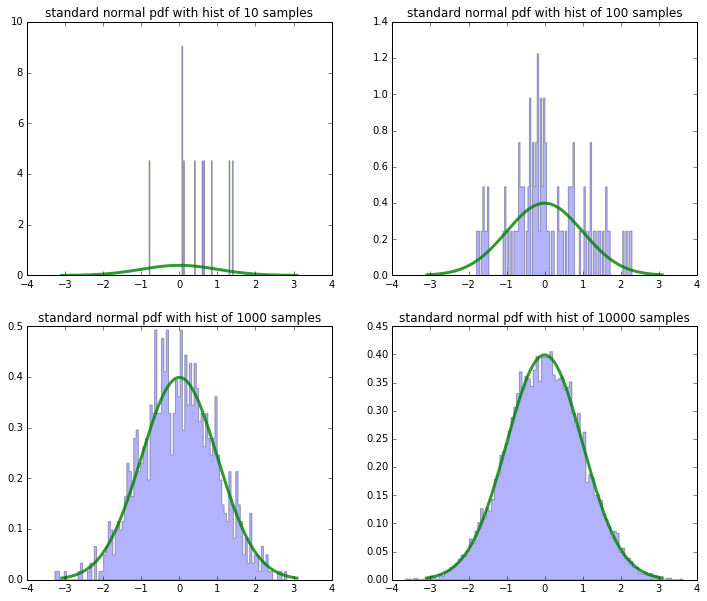

In [5]:
a = norm(loc=0, scale=1)

# this creates a grid of 2x2 plots
# axes is then a 2x2 np.ndarray
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# sample 1000 points from the 0.01 percentile to 0.99 percentile
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000) 

num_samples = [10, 100, 1000, 10000]
# we go through the axes one by one, need to make the 2x2 matrix linear before
for i, ax in enumerate(axes.reshape(4)):
    normal_dist = norm(loc=0, scale=1)
    ax.plot(x, normal_dist.pdf(x), 'g', lw=3, alpha=.8)
    
    ys = normal_dist.rvs(size=num_samples[i])
    ax.hist(ys, normed=True, bins=100, histtype="stepfilled", alpha=0.3)
    ax.set_title('standard normal pdf with hist of {} samples'.format(num_samples[i]))

We see that the more samples we take, the more the distribution of the samples converges against the pdf - as it should.

Generators are special kind of functions in Python. Instead of returning only a value, they return a (possible infinite) sequence of values. This works that the function runs until the <b>yield</b> keyword appears. Like <b>return</b> it returns the value given as parameter. If the generator is told to generate more values, the function the continues from the point of the last call of yield. As an example we write a generator that generates the natural numbers $\mathbb{N}_0$, i.e. $0, 1, 2, \dots$.

In [6]:
def natural_numbers():
    i = 0
    
    while True: # infinite loop?!
        yield i
        i += 1

In [7]:
gen = natural_numbers()
print type(gen)
print gen.next()
print [gen.next() for i in xrange(100)] # take 100 numbers, note that 0 was already generated!

<type 'generator'>
0
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


<b>Exercise 1</b>: Complete the code of the following three generators:

- uniform_gen(a,b): generates a randomly chosen element uniformly between a and b. Assert that a < b.

- normal_gen(mean, std): generates a randomly chosen element from the normal distribution with mean=mean and variance=std². Assert that std >= 0.

- data_gen(f, x_gen, noise_gen): Samples data points (x, y), where x is chosen from x_gen and y is f(x) + eps, where eps is chosen from noise_gen (see also the beginning of the chapter).

In [8]:
def uniform_generator(a, b):
    assert(a < b)
    dist = uniform(loc=a, scale=b-a)
    
    while True:
        yield dist.rvs(1)[0]
        
def normal_generator(mean, std):
    assert(std > 0)
    dist = norm(loc=mean, scale=std)
    
    while True:
        yield dist.rvs(1)[0]
        
def data_generator(f, x_gen, noise_gen):
    
    while True:
        x = x_gen.next()
        eps = noise_gen.next()
        
        yield x, f(x) + eps

In [9]:
import itertools
try: 
    num_gen = uniform_generator(1, 5)
    numbers = [num_gen.next() for _ in xrange(1000)]

    assert([1 <= num and num <= 5 for num in numbers])
    
    def constant_generator(c):
        while True:
            yield c

    data_gen = data_generator(lambda x: x**2, uniform_generator(-1, 1), constant_generator(0))
    
    assert(all([x**2 == y for x, y in itertools.islice(data_gen, 0, 1000)]))
    print "Code seems fine."
except AssertionError:
    print "Something is wrong..."

Code seems fine.


## 2. Posterior Distribution of $\theta$ and MAP

We are now perform a Bayesian linear regression on $f(x) = 5x + 3$, $x$ chosen uniformly in $[0, 5]$ and a noise of $2.5". We start with generating a data sample and visualising it.

In [10]:
sigma   = 2.5 # sigma of the noise, do not change this!

data_gen = data_generator(lambda x: 5*x + 3, uniform_generator(0, 5), normal_generator(0, sigma))
data = list(itertools.islice(data_gen, 0, 10)) # list of pairs (x, y)
x, y = zip(*data) # *data, makes it be called like zip((x[0], y[0]), ((x[1], y[1])), ...)
# = [ (x[0], x[1], ...), (y[0], y[1], ...) ]

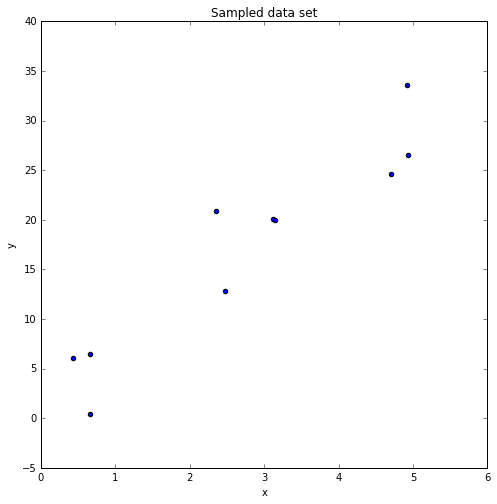

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Sampled data set")

We also add a bias. More precisely we extend the vector $x$ to a matrix by writing it as a column and adding a vector of $1$ next to it.

In [12]:
N = len(x)
X = np.column_stack((np.asarray(x), np.ones(N)))

<b>Exercise 2</b>: Given a data matrix $X$ with dimensions $N \times D$ and a label vector $y$ of dimension $D$ as well as a noise parameter $\sigma$ (standard deviation of the output noise) and a standard deviation $\sigma_p$ for the prior distribution of the weights $\theta$. Implement the missing parts of the functions:

- get_MAP: Returns the MAP estimate $\theta_{\text{MAP}}$ given $X, y, \sigma, \sigma_p$.

$$ \theta_{\text{MAP}} = \left(X^T X + \frac{\sigma^2}{\sigma_p^2} I\right)^{-1} X^T y. $$

- get_posterior_distribution_parameters: Returns the mean vector (equal to the MAP estimate) and covariance matrix $\Sigma$ for the posterior distribution of $\theta$ given $X$ and $y$.

$$ \Sigma^{-1} = \frac{1}{\sigma^2} X^T X + \frac{1}{\sigma_p^2} I. $$

In [13]:
def get_MAP(X, y, sigma, sigma_p):
    lmbd = (sigma / sigma_p)**2
    d = X.shape[1]
    theta_MAP = np.linalg.inv(np.dot(X.T, X) + lmbd * np.eye(d)).dot(X.T).dot(y)
    return theta_MAP

def get_posterior_distribution_parameters(X, y, sigma, sigma_p):
    d = X.shape[1]
    theta_MAP = get_MAP(X, y, sigma, sigma_p)
    covariance_matrix = (1.0 / sigma**2)* np.dot(X.T, X) + (1.0 / sigma_p**2) * np.eye(d)
    return theta_MAP, covariance_matrix

In [14]:
sigma_p = 5

theta_MAP = get_MAP(X, y, sigma=sigma, sigma_p=sigma_p)
print "theta (MAP estimate): {}".format(theta_MAP)

theta (MAP estimate): [ 5.56235526  1.87477788]


To use multivariate normals a different distribution has to be imported from scipy.stats. We visualize the posterior distribution of the weights.

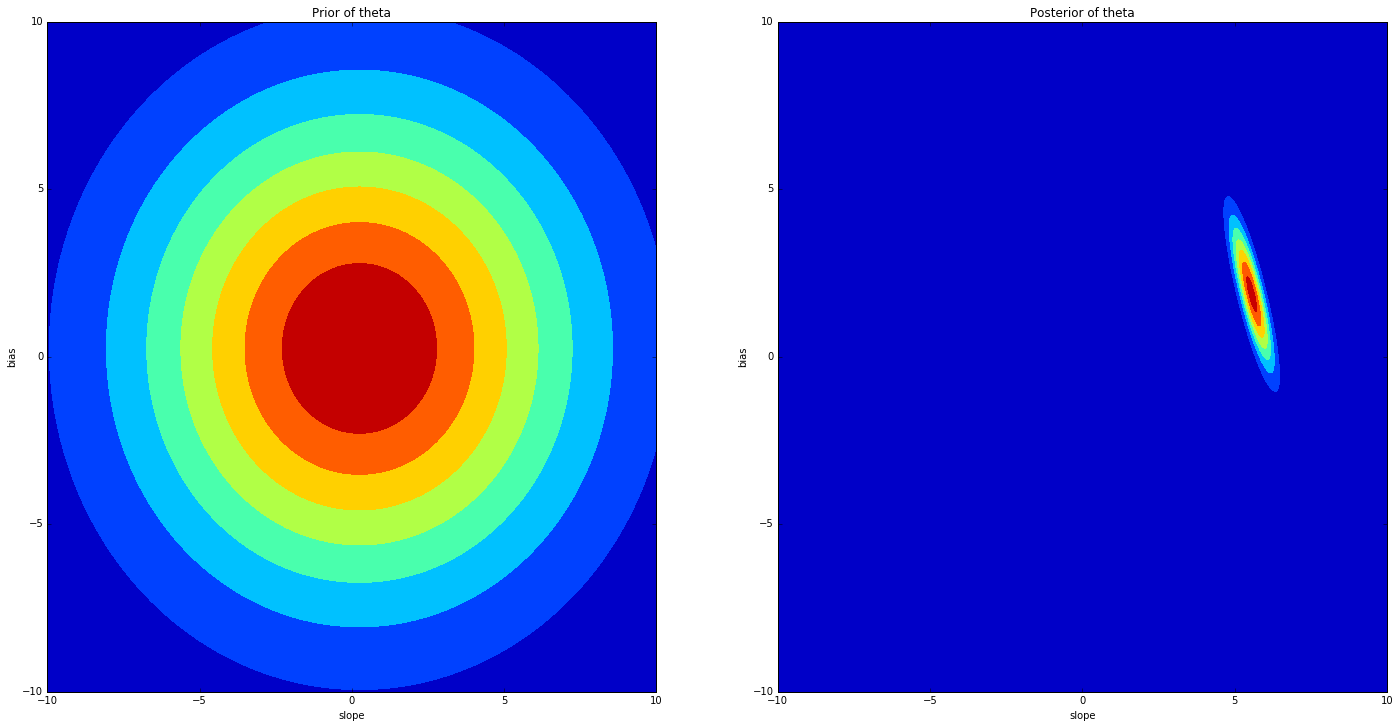

In [15]:
from scipy.stats import multivariate_normal

d = X.shape[1]
theta_prior = (sigma / sigma_p)**2 * np.ones(d) 
Sigma_prior = (1.0 / sigma_p**2) * np.eye(d)
theta_MAP, Sigma = get_posterior_distribution_parameters(X, y, sigma, sigma_p)

mvn_prior = multivariate_normal(theta_prior, np.linalg.inv(Sigma_prior))
mvn = multivariate_normal(theta_MAP, np.linalg.inv(Sigma))
thetas = mvn.rvs(5)

def generate_contour(mvn, ax):
    a, b = np.mgrid[-10:10:.01, -10:10:.01]
    pos = np.dstack((a, b))
    ax.contourf(a, b, mvn.pdf(pos))
    
plt.figure(figsize=(24, 12))

ax = plt.subplot(1, 2, 1)
ax.set_title("Prior of theta")
ax.set_xlabel("slope")
ax.set_ylabel("bias")
generate_contour(mvn_prior, ax)

ax = plt.subplot(1, 2, 2)
ax.set_title("Posterior of theta")
ax.set_xlabel("slope")
ax.set_ylabel("bias")
generate_contour(mvn, ax)

We visualize the MAP estimate and sample posterior curves.

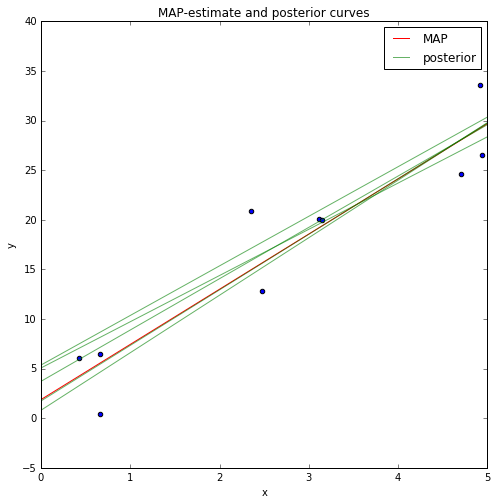

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title("MAP-estimate and posterior curves")

ps = np.linspace(0, 5, 1000)

def predict(theta):
    return lambda p: theta[0] * p + theta[1]
plt.plot(ps, map(predict(theta_MAP), ps), "r-", label="MAP")

for theta in thetas:
    plt.plot(ps, map(predict(theta), ps), "g-", alpha=0.6)
plt.legend(["MAP", "posterior"], loc="best")
plt.xlim([0, 5])
plt.show()